# Library import and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
import scipy.sparse as sp
from scipy import stats
from libreco.data import random_split, DatasetPure, split_by_ratio_chrono
from libreco.algorithms import LightGCN
from libreco.evaluation import evaluate



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv("C:\\Users\\marci\\OneDrive\\Pulpit\\archive\\interactions.csv",
                 # "C:\\Users\\fpazi\\Desktop\\projekty\\olx\\interactions.csv",
                 sep=',')

# EDA

## Basic statistics

In [3]:
df['event'].value_counts()

event
click                    58817263
contact_phone_click_1     1721338
bookmark                  1644602
chat_click                1399051
contact_chat               948470
contact_partner_click      459305
contact_phone_click_2      444497
contact_phone_click_3       67675
Name: count, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65502201 entries, 0 to 65502200
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 2.0+ GB


In [5]:
n_users = df['user'].nunique()
n_items = df['item'].nunique()

print('Number of users: ', n_users)
print('Number of items: ', n_items)

Number of users:  3295942
Number of items:  185395


In [6]:
n_events_per_user = df.groupby('user').size()
n_events_per_item = df.groupby('item').size()

print('Average number of events per user: ', round(np.mean(n_events_per_user), 2), ' with a standard deviation of ', np.std(n_events_per_user))
print('Average number of events per item: ', round(np.mean(n_events_per_item), 2), ' with a standard deviation of ', np.std(n_events_per_item))

Average number of events per user:  19.87  with a standard deviation of  47.762363188402105
Average number of events per item:  353.31  with a standard deviation of  624.7732106025969


In [7]:
print('Median number of events per user: ', round(np.median(n_events_per_user), 2))
print('Median number of events per item: ', round(np.median(n_events_per_item), 2))

Median number of events per user:  6.0
Median number of events per item:  137.0


## Number of interactions per user

In [8]:
n_events_per_user.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
dtype: float64

Text(0.5, 1.0, 'ECDF of interactions per user.')

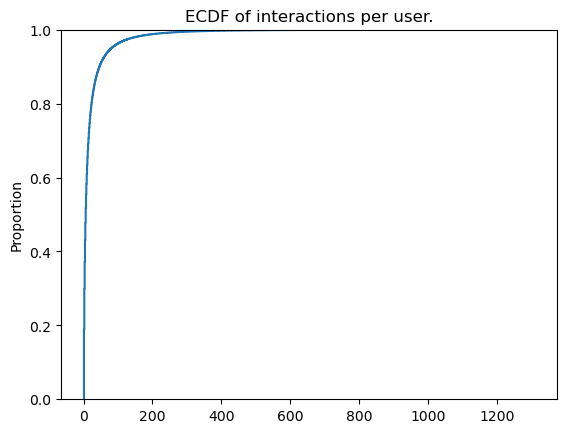

In [9]:
sns.ecdfplot(n_events_per_user).set_title("ECDF of interactions per user.")

Text(0.5, 1.0, 'Histogram of log(interactions) per item.')

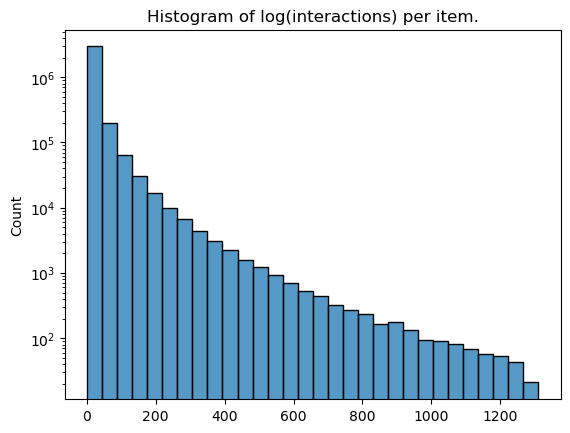

In [10]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1.set_title("Histogram of log(interactions) per item.")

Text(0.5, 1.0, 'Boxplot of interactions per user.')

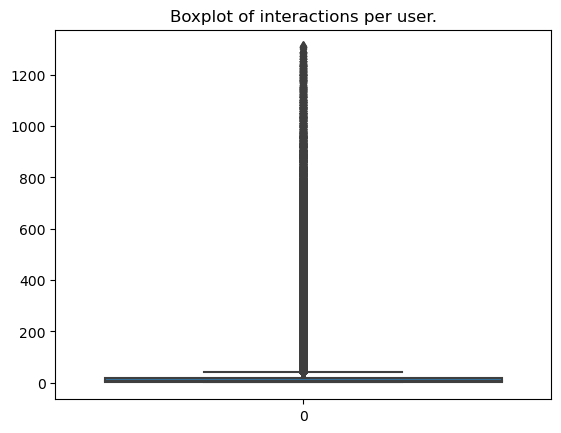

In [11]:
sns.boxplot(n_events_per_user).set_title("Boxplot of interactions per user.")

Text(0.5, 1.0, 'Boxplot of log(interactions) per user.')

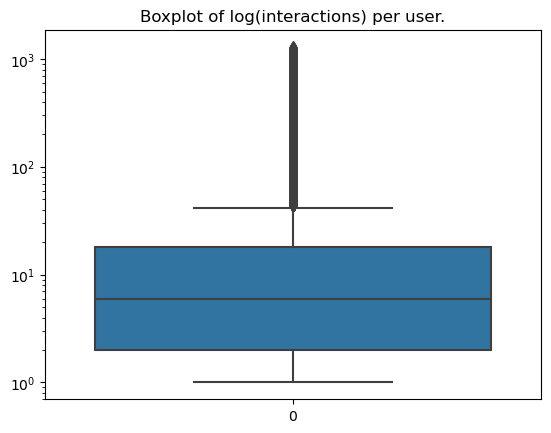

In [12]:
h = sns.boxplot(n_events_per_user)
h.set_yscale('log')
h.set_title("Boxplot of log(interactions) per user.")

## Number of interactions per item

In [13]:
n_events_per_item.describe()

count    185395.000000
mean        353.311583
std         624.774896
min           1.000000
25%           3.000000
50%         137.000000
75%         428.000000
max       15480.000000
dtype: float64

Text(0.5, 1.0, 'ECDF of interactions per item.')

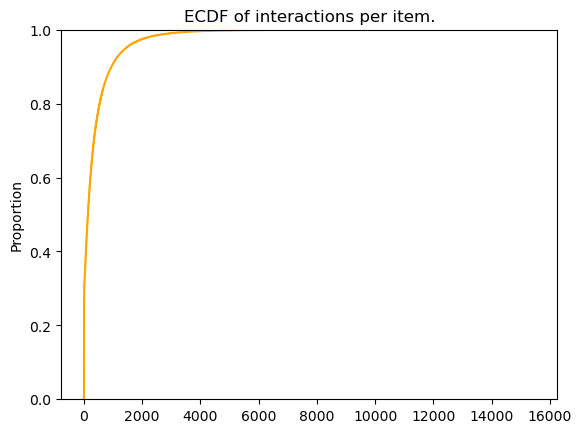

In [14]:
sns.ecdfplot(n_events_per_item, color='orange').set_title('ECDF of interactions per item.')

<Axes: title={'center': 'Histogram of log(interactions) per item.'}, ylabel='Count'>

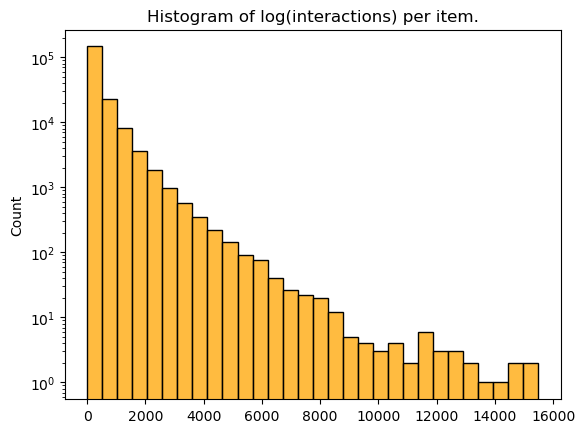

In [15]:
h2 = sns.histplot(n_events_per_item, bins=30, color='orange')
h2.set_yscale("log")
h2.set_title("Histogram of log(interactions) per item.")
h2

Text(0.5, 1.0, 'Boxplot of interactions per item.')

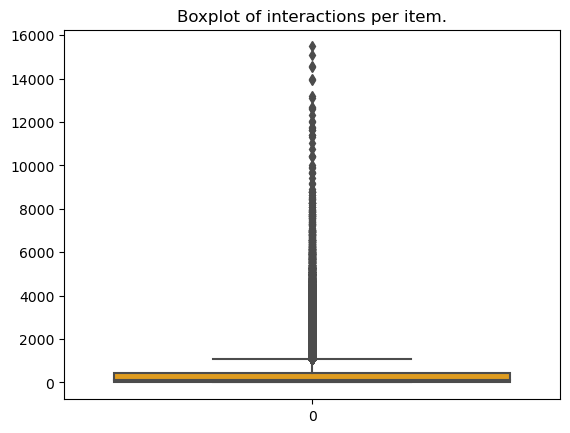

In [16]:
sns.boxplot(n_events_per_item, color='orange').set_title("Boxplot of interactions per item.")

<Axes: title={'center': 'Boxplot of log(interactions) per item.'}>

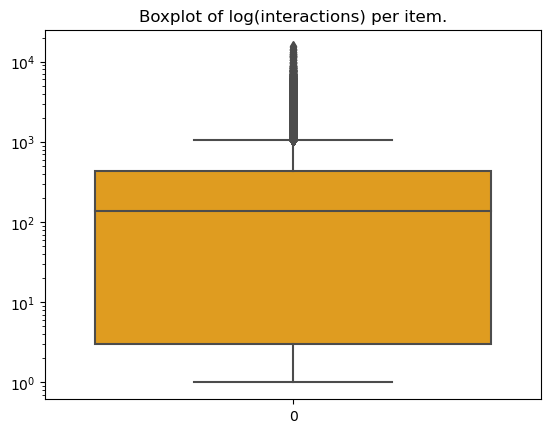

In [17]:
h4 = sns.boxplot(n_events_per_item, color='orange')
h4.set_yscale('log')
h4.set_title('Boxplot of log(interactions) per item.')
h4

# Data pre-processing

Split the values from the `event` column so that we can tailor our data frame to the task.

In [18]:
rating = {
    'click': 1,
    'bookmark': 2,
    'chat_click': 3,
    'contact_phone_click_1': 3,
    'contact_partner_click': 3,
    'contact_phone_click_2': 3,
    'contact_phone_click_3': 3,
    'contact_chat': 3
}
df['event'] = df['event'].map(rating)
df = df.rename(columns={'event': 'label'})
df = df.rename(columns={'timestamp': 'time'})

In [19]:
user_interaction_counts = df['user'].value_counts()
user_interaction_counts.describe()

count    3.295942e+06
mean     1.987359e+01
std      4.776237e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.800000e+01
max      1.310000e+03
Name: count, dtype: float64

We get rid of users with less than 100 interactions. In this way, we hope to weed out users who are not regulars. <br>We get rid of outliers using the 8 sigma method.

In [20]:
reg_users = user_interaction_counts[user_interaction_counts >= 100]
users_to_keep = reg_users[reg_users <= reg_users.mean() + 8*reg_users.std()].index
df = df[df['user'].isin(users_to_keep)]

In [21]:
n_events_per_user = df.groupby('user').size()
n_events_per_user.describe()

count    123531.000000
mean        202.475403
std         134.874360
min         100.000000
25%         121.000000
50%         156.000000
75%         229.000000
max        1283.000000
dtype: float64

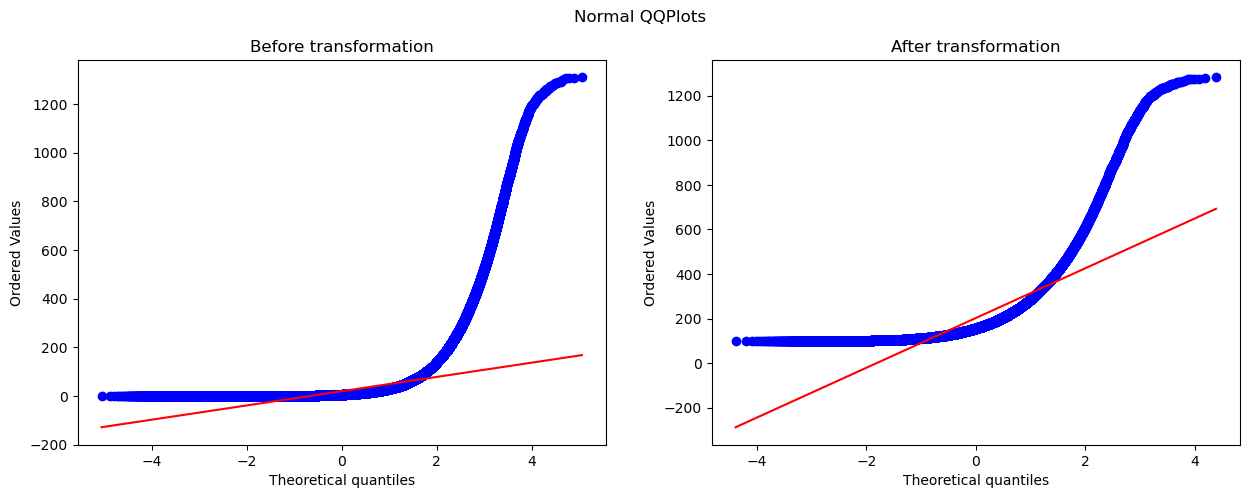

In [22]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))
stats.probplot(user_interaction_counts, dist='norm', plot=axis[0])
axis[0].set_title("Before transformation")

stats.probplot(n_events_per_user, dist='norm', plot=axis[1])
axis[1].set_title("After transformation")

figure.suptitle("Normal QQPlots")
plt.show()

<Axes: title={'center': 'Histogram of log(interactions) per user.'}, ylabel='Count'>

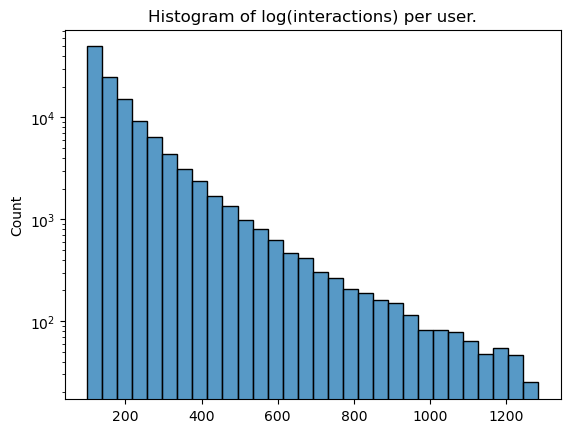

In [23]:
h1 = sns.histplot(n_events_per_user, bins=30)
h1.set_yscale("log")
h1.set_title('Histogram of log(interactions) per user.')
h1

Text(0.5, 1.0, 'Boxplot of interactions per user.')

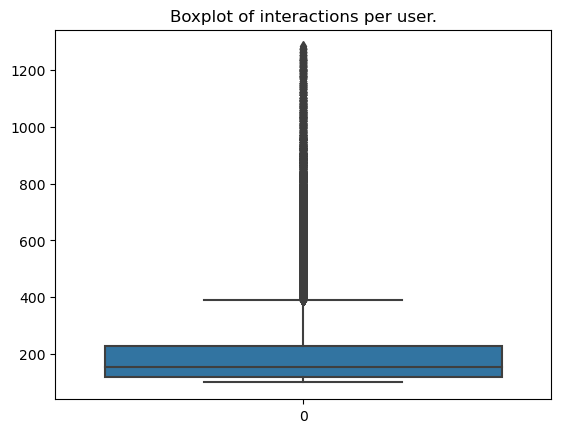

In [24]:
sns.boxplot(n_events_per_user.values).set_title('Boxplot of interactions per user.')

<Axes: title={'center': 'Boxplot of log(number of interactions) per user.'}>

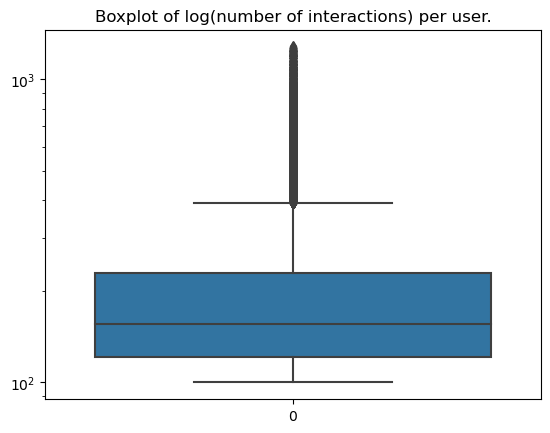

In [25]:
h = sns.boxplot(n_events_per_user.values)
h.set_yscale('log')
h.set_title('Boxplot of log(number of interactions) per user.')
h

We get rid of items with fewer than 1,000 interactions. In doing so, we hope to retain items that enjoy at least moderate success. <br>We get rid of outliers using the 8 sigma method.

In [26]:
item_interaction_counts = df['item'].value_counts()

In [27]:
item_interaction_counts.describe()

count    145085.000000
mean        172.395416
std         298.115472
min           1.000000
25%          23.000000
50%          74.000000
75%         195.000000
max        7276.000000
Name: count, dtype: float64

In [28]:
popular_item = item_interaction_counts[item_interaction_counts >= 1000]
items_to_keep = popular_item[popular_item <= popular_item.mean() + 8*popular_item.std()].index
df = df[df['item'].isin(items_to_keep)].reset_index(drop=True)

In [29]:
n_events_per_item = df.groupby('item').size()
n_events_per_item.describe()

count    3290.000000
mean     1577.923100
std       693.458523
min      1000.000000
25%      1139.000000
50%      1355.000000
75%      1754.000000
max      7080.000000
dtype: float64

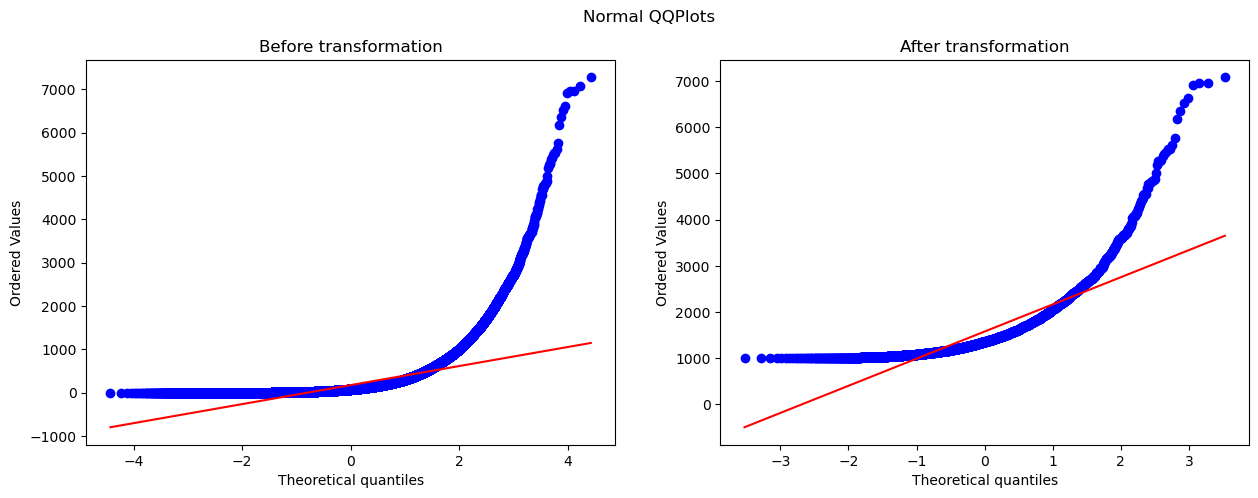

In [30]:
figure, axis = plt.subplots(1, 2, figsize=(15,5))
stats.probplot(item_interaction_counts, dist='norm', plot=axis[0])
axis[0].set_title("Before transformation")

stats.probplot(n_events_per_item, dist='norm', plot=axis[1])
axis[1].set_title("After transformation")

figure.suptitle("Normal QQPlots")
plt.show()

<Axes: title={'center': 'Histogram of log(interactions) per item.'}, ylabel='Count'>

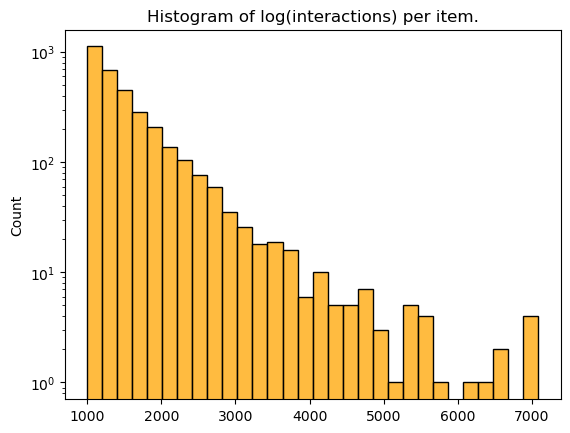

In [31]:
h2 = sns.histplot(n_events_per_item, bins=30, color='orange')
h2.set_yscale("log")
h2.set_title("Histogram of log(interactions) per item.")
h2

Text(0.5, 1.0, 'Boxplot of interactions per item.')

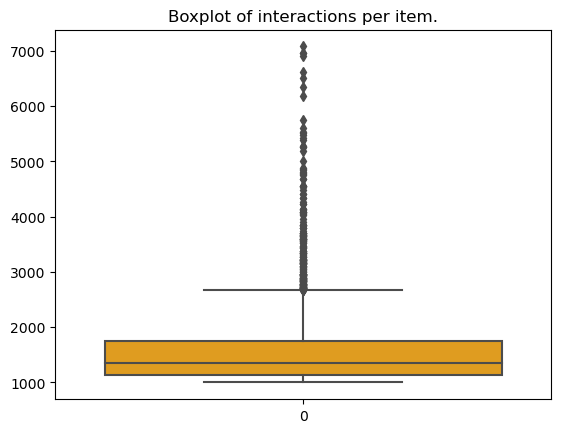

In [32]:
sns.boxplot(n_events_per_item.values, color='orange').set_title("Boxplot of interactions per item.")

<Axes: title={'center': 'Boxplot of log(number of interactions) per item.'}>

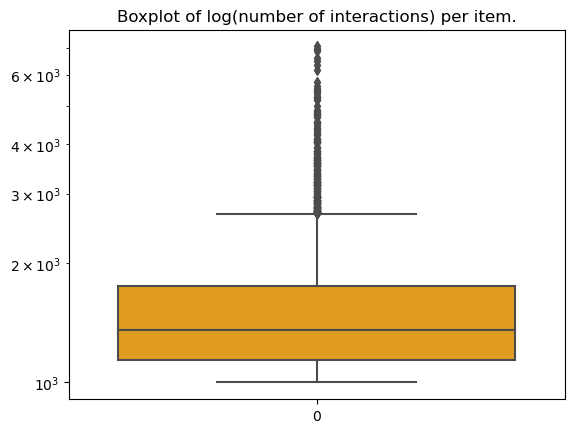

In [33]:
h4 = sns.boxplot(n_events_per_item.values, color='orange')
h4.set_yscale('log')
h4.set_title("Boxplot of log(number of interactions) per item.")
h4

 First filtering of the data frame. We select the 20% of users with the highest number of interactions.

In [34]:
user_interaction_counts = df['user'].value_counts()

top_20_threshold = user_interaction_counts.quantile(0.8)

top_20_users = user_interaction_counts[user_interaction_counts >= top_20_threshold].index

filtered_df = df[df['user'].isin(top_20_users)]

In [35]:
user_interaction_counts = filtered_df['user'].value_counts()

user_interaction_counts.describe()

count    25027.000000
mean       110.009030
std         60.541146
min         61.000000
25%         72.000000
50%         89.000000
75%        124.000000
max       1073.000000
Name: count, dtype: float64

We do the same for the items.

In [36]:
item_interaction_counts = df['item'].value_counts()

top_20_threshold = item_interaction_counts.quantile(0.8)

top_20_items = item_interaction_counts[item_interaction_counts >= top_20_threshold].index

filtered_df = filtered_df[filtered_df['item'].isin(top_20_items)]

In [37]:
item_interaction_counts = filtered_df['item'].value_counts()

item_interaction_counts.describe()

count     658.000000
mean     1560.200608
std       721.665109
min       191.000000
25%      1110.500000
50%      1428.000000
75%      1803.750000
max      5243.000000
Name: count, dtype: float64

We compare the ratio of items/users in the input data frame and the filtered one. As we can see, the ratio is almost identical.

In [38]:
count_users_before = df['user'].nunique()
count_items_before = df['item'].nunique()
count_users = filtered_df['user'].nunique()
print(f"Number of users: {count_users}")
count_items = filtered_df['item'].nunique()
print(f"Number of items: {count_items}")
print(f"Ratio of items to users after filtering: {count_items/count_users * 100}")
print(f"Ratio of items to users before filtering: {count_items_before/count_users_before * 100}")

Number of users: 25013
Number of items: 658
Ratio of items to users after filtering: 2.630632071322912
Ratio of items to users before filtering: 2.6687649053359075


Another filtering of the data frame.<br>
Now we randomly select $x\% $ of unique objects and users so that the machines we are working on do not have memory problems.

In [39]:
sample_percent_users = 0.8
sample_percent_items = 0.8

sampled_users = filtered_df.drop_duplicates('user').sample(frac=sample_percent_users, random_state=2024)

sampled_items = filtered_df.drop_duplicates('item').sample(frac=sample_percent_items, random_state=2024)

filtered_df_users = filtered_df[filtered_df['user'].isin(sampled_users['user'])]

filtered_df = filtered_df_users[filtered_df_users['item'].isin(sampled_items['item'])]

Again, let's check the item/user ratio.

In [40]:
count_users = filtered_df['user'].nunique()
print(f"Number of users: {count_users}")
count_items = filtered_df['item'].nunique()
print(f"Number of items: {count_items}")
print(f"Ratio of items to users after filtering: {count_items/count_users * 100}")
print(f"Ratio of items to users before filtering: {count_items_before/count_users_before * 100}")

Number of users: 19997
Number of items: 526
Ratio of items to users after filtering: 2.6303945591838773
Ratio of items to users before filtering: 2.6687649053359075


# Creating the model

We implement code from the LibRecommender library that divides the data into a training and evaluation set.

In [41]:
train_data, eval_data, test_data = random_split(filtered_df, multi_ratios=[0.6, 0.2, 0.2])
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 19954, n_items: 526, data density: 3.7593 %


In [42]:
best_lightgcn = LightGCN(
    task="ranking",
    data_info=data_info,
    loss_type="bpr",
    embed_size=32,
    n_epochs=3,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
    device="cuda"
)

In [43]:
%%time
best_lightgcn.fit(
    train_data,
    neg_sampling=True,
    verbose=0,
    eval_data=eval_data,
    metrics=["loss", "precision", "recall", "ndcg", "map"]
)

Training start time: 2024-03-07 09:18:31
CPU times: total: 4min 27s
Wall time: 1min 17s


In [44]:
%%time
results_best = evaluate(
    model=best_lightgcn,
    data=test_data,
    neg_sampling=True,
    metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
)
results_best

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 470.13it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1287/1287 [00:01<00:00, 1273.35it/s]


CPU times: total: 5.11 s
Wall time: 2.29 s


{'loss': 0.5047070302504733,
 'roc_auc': 0.90561480694741,
 'precision': 0.052766266058847905,
 'recall': 0.10773723192844956,
 'ndcg': 0.21266662370911354,
 'map': 0.15495182247195582}

The result above are the results we were asked to find, k=10 which is default for the package. Below we explored different values of k to see how the results change. We also tried using different recommended loss functions and different learning rate. It is important to note that the problem we had last week, loss function increasing with further epochs, was connected with the learning rate. If the learning rate was too big the loss function started to increase. We found that learning rate lr=1e-3 is the most optimal tradeoff between not increasing loss function and best results.

In [45]:
loss_function = "bpr"

metrics = ["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
k_values = [50, 20, 10, 5, 3, 1]

results_df = pd.DataFrame(index=pd.MultiIndex.from_product([k_values]), columns=metrics)

for k in k_values:
    results = evaluate(
        model=best_lightgcn,
        data=test_data,
        neg_sampling=True,
        metrics=metrics,
        k=k
    )
    for metric, value in results.items():
        results_df.at[k, metric] = value

eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 531.91it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 434.48it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 455.16it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps par

In [46]:
results_df

,loss,precision,recall,ndcg,map,roc_auc
50,0.504707,0.025088,0.246825,0.266246,0.143044,0.905615
20,0.504707,0.0416,0.167081,0.243203,0.152715,0.905615
10,0.504707,0.052766,0.107737,0.212667,0.154952,0.905615
5,0.504707,0.064567,0.066503,0.177111,0.146634,0.905615
3,0.504707,0.073163,0.045604,0.149203,0.13347,0.905615
1,0.504707,0.090396,0.018898,0.090396,0.090396,0.905615


In [47]:
loss_functions = ["max_margin","cross_entropy", "focal"]
metrics = ["loss", "precision", "recall", "ndcg", "map", "roc_auc"]

results_df = pd.DataFrame(index=loss_functions, columns=metrics)

for loss_func in loss_functions:
    lossgcn = LightGCN(
        task="ranking",
        data_info=data_info,
        loss_type=loss_func,
        embed_size=32,
        n_epochs=3,
        lr=1e-3,
        batch_size=2048,
        num_neg=1,
        device="cuda"
    )
    lossgcn.fit(
        train_data,
        neg_sampling=True,
        verbose=0,
        eval_data=eval_data,
        metrics=["loss", "precision", "recall", "ndcg", "map"]
    )
    evaluate(
        model=lossgcn,
        data=test_data,
        neg_sampling=True,
        metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
    )
    results = evaluate(
        model=lossgcn,
        data=test_data,
        neg_sampling=True,
        metrics=["loss", "precision", "recall", "ndcg", "map", "roc_auc"]
    )
    for metric, value in results.items():
        results_df.at[loss_func, metric] = value

Training start time: 2024-03-07 09:20:03


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 508.78it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 497.89it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1287/1287 [00:00<00:00, 1307.29it/s]


Training start time: 2024-03-07 09:21:24


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 479.04it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 467.37it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1287/1287 [00:01<00:00, 1269.79it/s]


Training start time: 2024-03-07 09:24:00


eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 408.89it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_pointwise: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 403.03it/s]
C:\Users\marci\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|█████████████████████████████████████████████████████████████| 1287/1287 [00:01<00:00, 1074.99it/s]


In [59]:
for metric, value in results_best.items():
    results_df.at['bpr', metric] = value
results_df

,loss,precision,recall,ndcg,map,roc_auc
max_margin,0.499883,0.055009,0.113511,0.222311,0.162532,0.909603
cross_entropy,0.47513,0.053124,0.110188,0.215981,0.15711,0.916417
focal,0.591278,0.055071,0.112951,0.22107,0.160825,0.915601
best_model,0.504707,0.052766,0.107737,0.212667,0.154952,0.905615
bpr,0.504707,0.052766,0.107737,0.212667,0.154952,0.905615


# Additional task

Dataframe containing users and an array of items they have interacted with.

In [49]:
df_all = filtered_df.groupby('user')['item'].apply(list).reset_index(name='items')
df_all = df_all.sort_values(by='user')

Dataframe containing users and an array of items with which they have interacted at a higher level.

In [50]:
df_23 = filtered_df[filtered_df['label'].isin([2, 3])].groupby('user')['item'].apply(list).reset_index(name='items')
all_users = filtered_df[['user']].drop_duplicates()
df_23 = pd.merge(all_users, df_23, on='user', how='left')
df_23['items'] = df_23['items'].apply(lambda x: x if isinstance(x, list) else [])
df_23 = df_23.sort_values(by='user')

Dataframe containing users and an array of items that are recommended to them.

In [51]:
unique_users = filtered_df['user'].unique()
recommendations_data = []

Recommendations for each user.

In [52]:
for user in unique_users:
    recommendations = best_lightgcn.recommend_user(user=user, n_rec=10).get(user)
    recommendations_data.extend([(user, recommendations)])

df_rec = pd.DataFrame(recommendations_data, columns=['user', 'items'])
df_rec = df_rec.sort_values(by='user')


Detect unknown user: 3149299
Detect unknown user: 2766154
Detect unknown user: 1743091
Detect unknown user: 2251704
Detect unknown user: 1157987
Detect unknown user: 2120442
Detect unknown user: 1234407
Detect unknown user: 636211
Detect unknown user: 1010350
Detect unknown user: 2113102
Detect unknown user: 908177
Detect unknown user: 1332133
Detect unknown user: 2742520
Detect unknown user: 894227
Detect unknown user: 1998316
Detect unknown user: 1075223
Detect unknown user: 953128
Detect unknown user: 3280953
Detect unknown user: 1550605
Detect unknown user: 2670578
Detect unknown user: 1997755
Detect unknown user: 3225188
Detect unknown user: 920932
Detect unknown user: 2743560
Detect unknown user: 540783
Detect unknown user: 1187568
Detect unknown user: 2000027
Detect unknown user: 2384208
Detect unknown user: 1330051
Detect unknown user: 121505
Detect unknown user: 1914074
Detect unknown user: 377547
Detect unknown user: 2064288
Detect unknown user: 3205838
Detect unknown user: 1

In [53]:
def find_intersection(row, df):
    rec_items = row['items']
    all_items = df.loc[df['user'] == row['user'], 'items'].values
    if len(rec_items) == 0 or len(all_items) == 0:
        return []
    else:
        intersection = np.intersect1d(rec_items, all_items[0])
        return intersection

Restriction of recommended items to those with which the user has had any interaction.

In [54]:
df_rec['items'] = df_rec.apply(lambda row: find_intersection(row, df_all), axis=1)

df_match = df_rec.copy()

Listing of items both recommended and those with which the user has had higher-level interaction.

In [55]:
df_match['items'] = df_match.apply(lambda row: find_intersection(row, df_23), axis=1)

`precision`

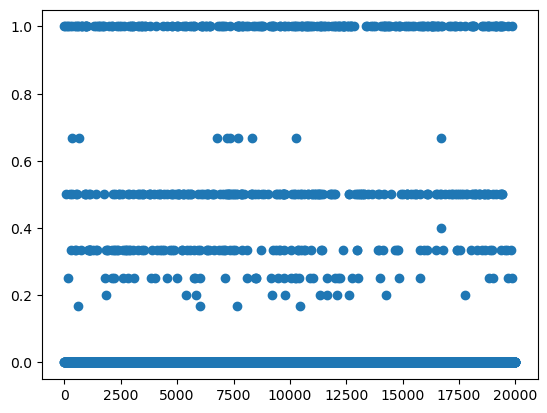

In [56]:
(df_match['items'].apply(len)/df_rec['items'].apply(len)).sum(skipna=True)/len(df_match['items']) 
matplotlib.pyplot.plot(df_match['items'].apply(len)/df_rec['items'].apply(len), 'o')

`recall`

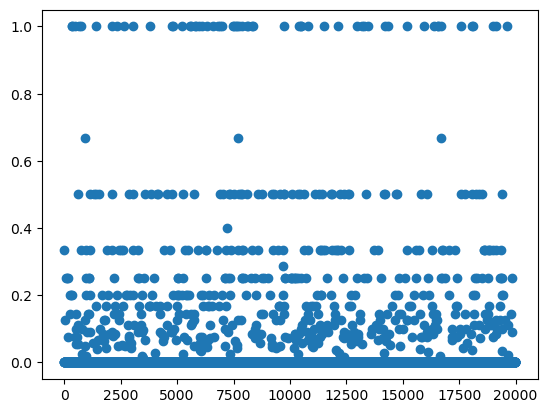

In [57]:
(df_match['items'].apply(len)/df_23['items'].apply(len)).sum(skipna=True)/len(df_match['items']) 
matplotlib.pyplot.plot(df_match['items'].apply(len)/df_23['items'].apply(len), 'o')